# Калибровка камеры
Инструкция по калибровки с сайта OpenCV https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

# Способы преобразования координат из пикселей в миллиметры

# Перевод полученных значения центра объекта из пикселей в миллиметры, с помощью вычисления соотношения реальных размеров рабочей области в миллиметрах и количества пикселей, по каждой из осей, которые ей соответствуют.

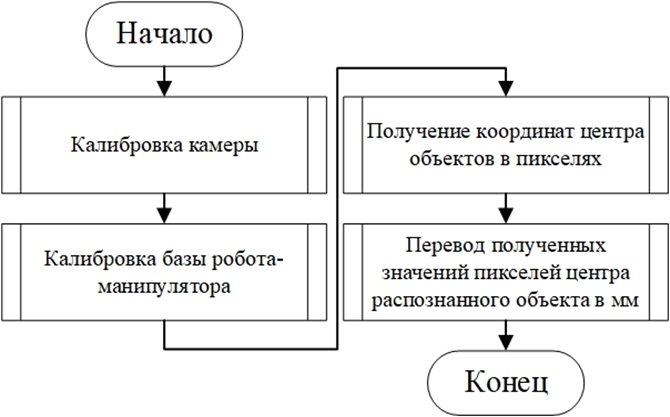

Представьте, что ваша камера (или телефон) — это немного кривое зеркало. Оно искажает реальность: прямые линии по краям кадра становятся изогнутыми, а некоторые объекты могут казаться чуть ближе или дальше, чем на самом деле. Калибровка камеры — это процесс, который помогает нам измерить эти искажения и научить компьютер их исправлять.

Какие бывают искажения?
Радиальное искажение (Выпуклость/Вогнутость)

Как выглядит: Прямые линии (особенно по краям фото) выгибаются наружу, как у рыбий глаз (barrel), или внутрь, как у подушкообразного объектива (pincushion).

Простая причина: Объектив камеры не идеально плоский, а больше похож на полусферу, поэтому свет по краям преломляется сильнее, чем в центре.

Тангенциальное искажение (Перекос)

Как выглядит: Изображение кажется "наклоненным" или "скрученным". Представьте, что вы смотрите на картинку не прямо, а под небольшим углом.

Простая причина: Датчик камеры и линза объектива установлены не совсем идеально параллельно друг другу. Это как криво повешенная картина на стене.

Ниже показано одно изображение, на котором два края шахматной доски отмечены красными линиями. Но вы можете видеть, что граница шахматной доски не является прямой линией и не совпадает с красной линией. 
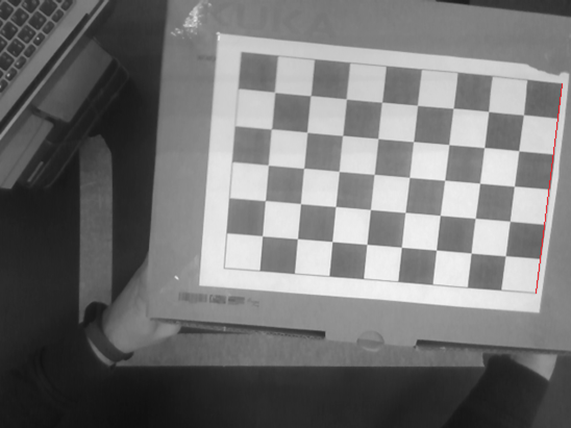

Чтобы описать эти искажения математически, нам нужно найти 5 коэффициентов искажения (те k1, k2, k3, p1, p2). По сути, это "рецепт" того, как именно наша камера искажает картинку.

Что еще нужно знать о камере?
Помимо искажений, у каждой камеры есть свои уникальные "внутренние" параметры, как отпечатки пальцев. Они записываются в матрицу камеры:

Фокусное расстояние (fx, fy): Грубо говоря, это "зум" камеры. Определяет, насколько крупно объекты будут в кадре.

Оптические центры (cx, cy): Это координаты самой середины вашего изображения. Не всегда это ровно центр кадра из-за погрешностей производства.

Важный момент: Эти параметры (матрица камеры и коэффициенты искажения) не меняются от снимка к снимку. Рассчитали их один раз для своей камеры — и можно использовать для всех будущих фотографий.

Как же провести эту калибровку?
Нам нужен эталонный объект, форма которого нам заранее точно известна. Идеальный кандидат — шахматная доска.

Почему шахматная доска?

У нее идеально прямые линии и четкие углы, которые легко найти на картинке.

Мы заранее знаем, как расположены ее углы относительно друг друга (например, углы находятся в точках (0,0), (1,0), (2,0) и т.д.).

Процесс выглядит так:

Делаем снимки: Делаем около 10-15 фотографий шахматной доски с разных ракурсов, поворачивая и наклоняя ее. Чем больше разнообразных ракурсов, тем точнее будет результат.

In [1]:
import cv2
import numpy as np
import glob

cap = cv2.VideoCapture(1)

if cap.isOpened() is True:
    i = 0
    while(True):
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Преобразовать в серый канал
        cv2.imshow('frame', gray)
        if i % 50 == 0:
            cv2.imwrite('C:\\Users\\djnik\\chess (OpenCv)\\' + str(i//50) + '.png', gray)
        if (cv2.waitKey(1) & 0xFF == ord('q')) or (i==250):
            break
        i += 1
    cap.release()
    cv2.destroyAllWindows()

Находим углы на изображениях: С помощью OpenCV проходит по всем фотографиям и ищет на них внутренние углы шахматной доски (не внешние края, а точки, где сходятся черные и белые квадраты). Для доски 8x8 клеток таких углов будет 7x7.

Сопоставляем точки: Для каждого найденного угла на фотографии (2D-координаты) программа знает, где он находится на реальной шахматной доске (3D-координаты). Поскольку доска плоская, мы можем считать, что ее третья координата (Z) всегда равна нулю, что сильно упрощает расчеты.

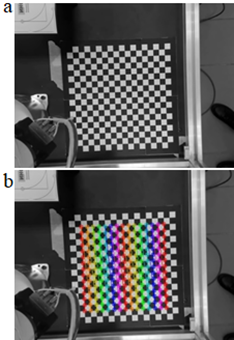

Производим расчет: Используя все эти пары точек ("этот угол на фото соответствует вот этому углу на реальной доске"), программа решает сложную математическую задачу и находит:

Коэффициенты искажения (k1, k2, k3, p1, p2) — чтобы убрать кривизну.

Матрицу камеры — чтобы знать ее фокусное расстояние и центр.

Внешние параметры (для каждого снимка) — чтобы понять, как была повернута и сдвинута камера относительно доски на каждом конкретном фото.

In [ ]:
import cv2
import numpy as np
import os
import glob
 
# Определение размеров шахматной доски (количество ВНУТРЕННИХ углов)
# 6x9 - означает 6 углов по ширине, 9 по высоте (для доски 7x10 клеток)
CHECKERBOARD = (6,9)

# Критерии для уточнения углов (максимум 30 итераций или точность 0.001)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# Создание вектора для хранения 3D точек (мировые координаты) для каждого изображения
objpoints = []
# Создание вектора для хранения 2D точек (координаты на изображении) для каждого изображения
imgpoints = [] 
 
# Определение мировых координат для 3D точек
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
# Создание сетки координат (0,0), (1,0), (2,0)... (5,8) для углов доски
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

prev_img_shape = None
 
# Извлечение путей ко всем изображениям в папке './images' с расширением .jpg
images = glob.glob('./images/*.jpg')

# Обработка каждого изображения
for fname in images:
    img = cv2.imread(fname)
    # Конвертация в оттенки серого (нужно для поиска углов)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Поиск углов шахматной доски на изображении
    # Используются флаги для улучшения detection:
    # - ADAPTIVE_THRESH: адаптивная thresholding
    # - FAST_CHECK: быстрая проверка
    # - NORMALIZE_IMAGE: нормализация изображения
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
    """
    Если найдено нужное количество углов,
    уточняем пиксельные координаты и отображаем
    их на изображениях шахматной доски
    """
    if ret == True:
        # Добавляем 3D точки объекта (мировые координаты)
        objpoints.append(objp)
        
        # Уточнение пиксельных координат для найденных 2D точек
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
         
        # Добавляем уточненные 2D точки (координаты на изображении)
        imgpoints.append(corners2)
 
        # Рисуем и отображаем углы на изображении
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
     
    # Показываем изображение с отмеченными углами
    cv2.imshow('img',img)
    cv2.waitKey(0)
 
# Закрываем все окна после обработки
cv2.destroyAllWindows()
 
# Получаем размеры изображения (высота и ширина)
h,w = img.shape[:2]
 
"""
Выполнение калибровки камеры путем передачи:
- известных 3D точек (objpoints)
- соответствующих пиксельных координат обнаруженных углов (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
 
# Вывод результатов калибровки
print("Матрица камеры (внутренние параметры): \n")
print(mtx)
print("Коэффициенты искажения: \n")
print(dist)
print("Векторы вращения для каждого изображения: \n")
print(rvecs)
print("Векторы перемещения для каждого изображения: \n")
print(tvecs)

Ключевые моменты кода:
CHECKERBOARD = (6,9) - Указывает количество внутренних углов (6 по ширине, 9 по высоте)

objp - Создает сетку 3D точек в мировых координатах, где Z=0 (доска лежит в плоскости XY)

Поиск углов - Используются дополнительные флаги для улучшения detection

Калибровка - Функция calibrateCamera находит:

mtx - матрицу камеры (фокусное расстояние, оптический центр)

dist - коэффициенты дисторсии

rvecs, tvecs - положение камеры для каждого изображения

# Калибровка базы робота и соотнесение стартовых точек 

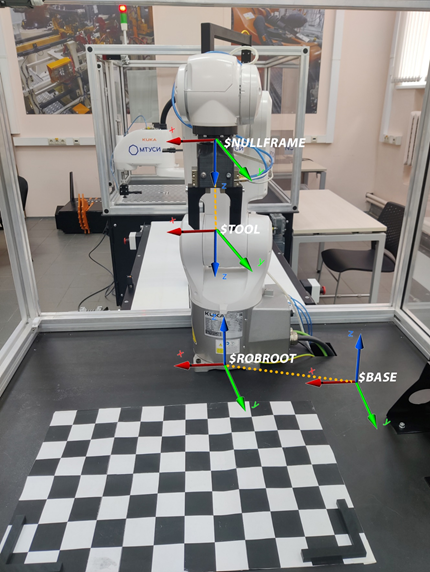

In [ ]:
import numpy as np
import cv2
import glob
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:6, 0:6].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.
images = glob.glob('C:\\Users\\djnik\\chess (OpenCv)\\*.png')
i = 0
x = 4
y = 3
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (x, y), None)
    # If found, add object points, image points (after refining them)
    if ret:
        i += 1
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        for i in range(corners.shape[0]):
            z1 = int(corners[0,0,1])
            z2 = int(corners[0,0,0])
            z3 = int(corners[((x*y)-1),0,1])
            z4 = int(corners[((x*y)-1),0,0])
            #print(" -- Refined Corner [", i, "]  (", corners[i,0,0], ",", corners[i,0,1], ")")           
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (x, y), corners2, ret)
        cv2.imshow('img', img)
        print (z1,":",z3,",",z2,":",z4)
        cv2.imwrite('C:\\Users\\djnik\\chess\\chesssss\\00'+str(i)+'.jpg', img)
        cv2.waitKey(50)
        
cv2.destroyAllWindows()

Получение значения центра объекта в пикселях (Любым методом компьютерного зрения)

Перевод значения центра объекта из пикселей в миллиметры

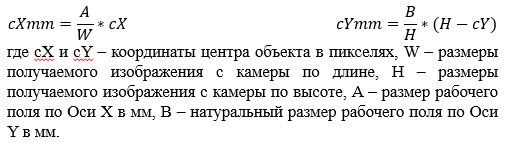

# Определение насколько сдвинут центр объекта относительно центра фланца робота через фокусное расстояние камеры и расстояние до объекта по вертикальной оси.

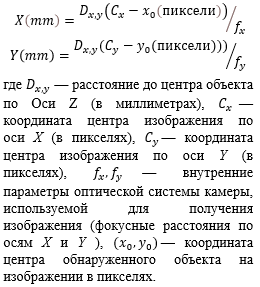

Тестирование на шахматной доске
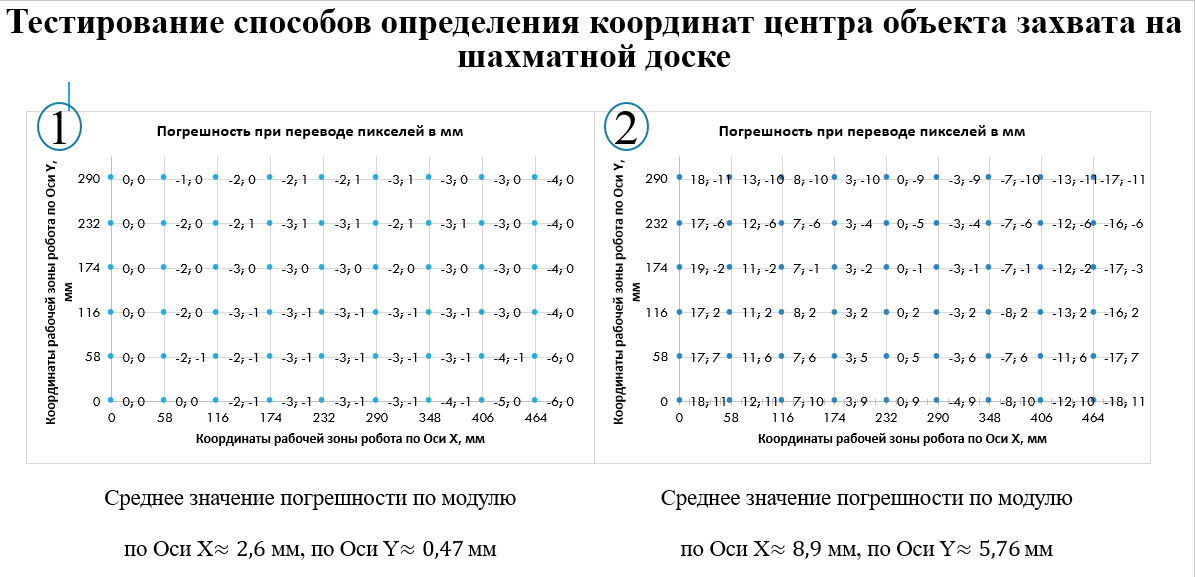

Тестирование на реальном объекте
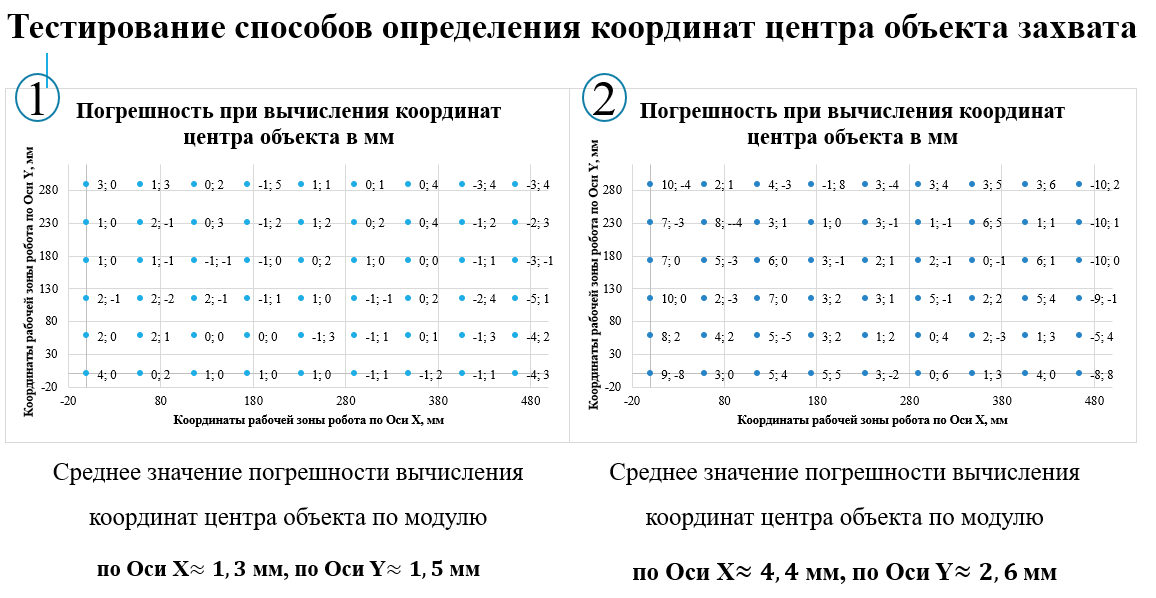
Для сравнения двух способов определения центра объекта проведено 54 эксперимента. В каждом эксперименте центр металлической заготовки квадратного сечения располагался в рабочей зоне манипулятора, затем производилось ее распознавание и расчёт координат в мм двумя способами. Затем заготовка сдвигалась на 58мм и эксперимент повторялся.
На рисунках приведены графики, на которых отмечены точки, в которых располагался центр объекта и погрешности расчета координат относительно фланца манипулятора.
Погрешности второго способа связаны с тем, что при удалении объектов от центра фланца стереокамера вычисляет расстояние до объекта по вертикальной оси с погрешностями, в связи с чем, растет погрешность вычисления координат. 
К аналогичному выводу пришли исследователи в РФ, которые решали задачу оценки пространственного положения яблок. Ошибка в их исследовании получилась в среднем около 7–12 миллиметров и увеличивалась по мере удаления объектов от камеры, при использовании Intel RealSense D415i. 

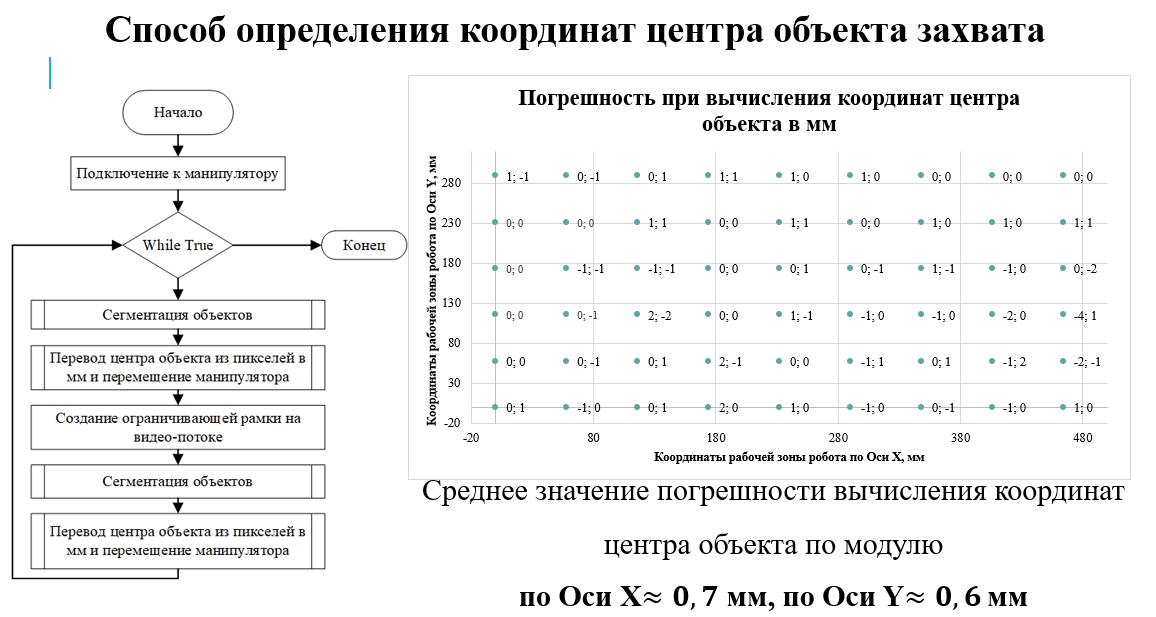

Для уменьшения погрешности можно поступить следующим образом. Делать две итерации. На первой итерации происходит определение  объекта, расчет координат центра объекта и перемещении манипулятора над объектом, далее происходит вторая итерация. В таком случае удается избежать погрешностей, т.к. объект находится всегда практически в центре кадра.